In [20]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 5.2 MB/s eta 0:00:00 MB/s eta 0:00:01


## Computing Category similarity 

I compute an events similarity to each category by computing the cosine similarity of their embeddings. using sentence embeddings. 

To compute the embedding of an event I concatenate it's name and impact and use the sentence transformer to compute the embedding. 
To comput the embeddings of the categories, I use the average embedding of the events in the category.

I then keep the smallest number of categories that account for at least 35% of the weights in the normalized weight vector of the categories representing the event. I put those categories to 1 and the others to 0 this also alowed me to remove the 'Other' category.


In [111]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load the CSV data
data = pd.read_csv('data/modified_data.csv')

# Extract unique categories, excluding 'Other'
categories = data['Broad Category'].unique()
categories = [category for category in categories if category != 'Other']

# Pre-trained SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to get SBERT embeddings
def get_embedding(text):
    embedding = model.encode(text, convert_to_tensor=True)
    return embedding.cpu().detach().numpy()

# Concatenate event name and impact for embeddings
data['combined_text'] = data['Name of Incident'] + ' ' + data['Type of Event'] + data['Impact']
data['embedding'] = data['combined_text'].apply(get_embedding)

# Compute average embedding for each category
category_embeddings = {}
for category in categories:
    category_events = data[data['Broad Category'] == category]
    embeddings = np.array(category_events['embedding'].tolist())
    category_embedding = np.mean(embeddings, axis=0)
    category_embeddings[category] = category_embedding

# Compute similarity between event embeddings and category embeddings
similarity_scores = []
for i, row in data.iterrows():
    event_embedding = row['embedding']
    scores = {category: cosine_similarity(event_embedding.reshape(1, -1), category_embedding.reshape(1, -1))[0][0]
              for category, category_embedding in category_embeddings.items()}
    similarity_scores.append(scores)

# Keep only the categories that together represent at least threshold% of the vector
def keep_top_categories(scores, threshold=0.38):
    # Normalize the scores so that their sum equals 1
    total_score = sum(scores.values())
    normalized_scores = {category: score / total_score for category, score in scores.items()}

    sorted_scores = sorted(normalized_scores.items(), key=lambda item: item[1], reverse=True)
    cumulative_sum = 0
    selected_categories = {}
    for category, score in sorted_scores:
        if cumulative_sum < threshold:
            cumulative_sum += score
            selected_categories[category] = 1
        else:
            selected_categories[category] = 0
    return selected_categories


# Apply the function to each event
filtered_similarity_scores = [keep_top_categories(score_dict) for score_dict in similarity_scores]

# Create a DataFrame with the filtered similarity scores
filtered_similarity_df = pd.DataFrame(filtered_similarity_scores)

# Combine with original data
final_df = data.join(filtered_similarity_df, rsuffix='_selected')
final_df.drop(columns=['embedding', 'combined_text'], inplace=True)

# Save the processed data
final_df.to_csv('processed_events_selected.csv', index=False)


In [112]:
# Count the number of ones for each category in the filtered_similarity_df
category_counts = filtered_similarity_df.sum().sort_values(ascending=False)

# Display the counts
category_counts

Political Events                             752
Social and Cultural Events                   720
Military and Conflict                        501
International Relations and Diplomacy        234
Economic and Infrastructure Development      187
Historical and Monumental                    173
Legal and Judicial Changes                   160
Crisis and Emergency Response                158
Technological and Scientific Advancements    134
Environmental and Health                     103
Social and Civil Rights                       15
dtype: int64

In [113]:
#print trhe average number of categories per event
category_counts.sum() / len(final_df)

2.8622262773722627

/var/folders/hg/m_l4_1m14_n0nfz7gdn_lbdw0000gn/T/ipykernel_9974/110766220.py:29: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  optimal_order = optimal_leaf_ordering(linkage_matrix, distance_matrix.values)


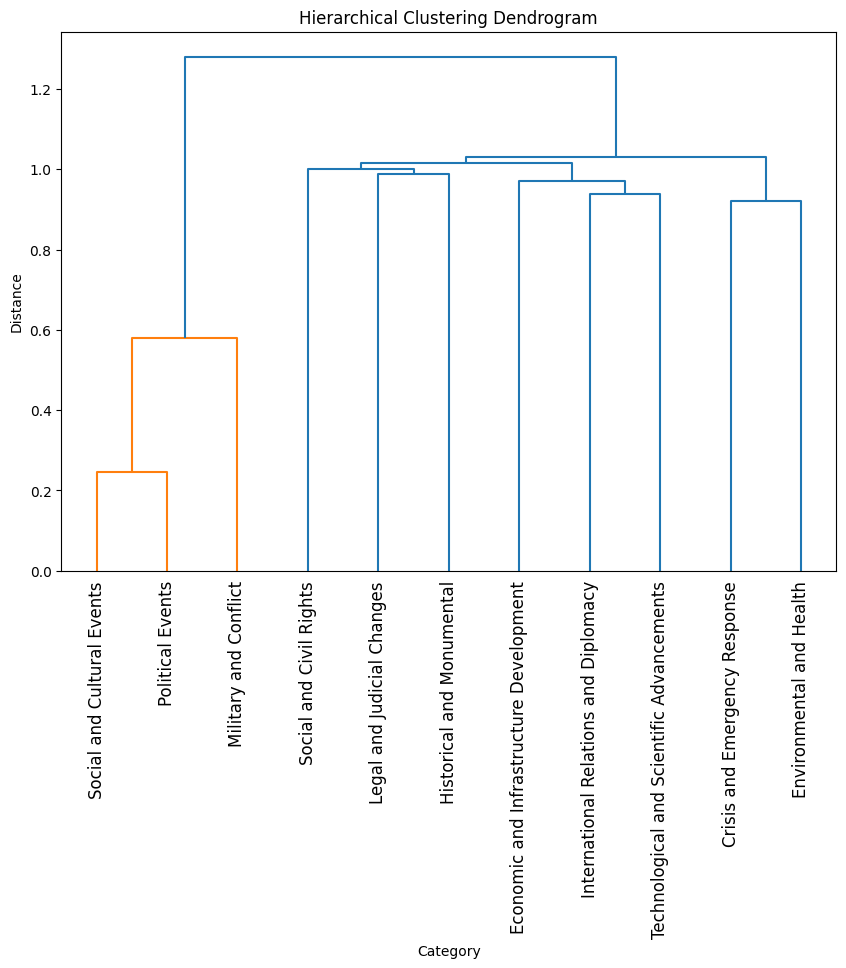

Optimal Circular Category Order: ['Political Events', 'Military and Conflict', 'Social and Civil Rights', 'Legal and Judicial Changes', 'Historical and Monumental', 'Economic and Infrastructure Development', 'International Relations and Diplomacy', 'Technological and Scientific Advancements', 'Crisis and Emergency Response', 'Environmental and Health', 'Social and Cultural Events']


In [114]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, dendrogram
import matplotlib.pyplot as plt

# Load the processed data with selected categories
final_df = pd.read_csv('processed_events_selected.csv')

# Extract the columns containing the selected categories
selected_category_columns = [col for col in final_df.columns if col in categories]

# Compute the co-occurrence matrix
co_occurrence_matrix = final_df[selected_category_columns].T.dot(final_df[selected_category_columns])

# Convert the co-occurrence matrix to a similarity matrix (normalizing by the max value)
similarity_matrix = co_occurrence_matrix / co_occurrence_matrix.max().max()

# Convert similarities to distances
distance_matrix = 1 - similarity_matrix

# Ensure the diagonal is zero
np.fill_diagonal(distance_matrix.values, 0)

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# Optimize the leaf order
optimal_order = optimal_leaf_ordering(linkage_matrix, distance_matrix.values)

# Extract the initial order from the dendrogram
initial_order = [selected_category_columns[i] for i in dendrogram(optimal_order, no_plot=True)['leaves']]

# Function to calculate the circular distance
def circular_distance(order, distance_matrix, category_indices):
    total_distance = 0
    n = len(order)
    for i in range(n):
        idx1 = category_indices[order[i]]
        idx2 = category_indices[order[(i + 1) % n]]
        total_distance += distance_matrix[idx1, idx2]
    return total_distance

# Map category names to indices
category_indices = {category: idx for idx, category in enumerate(selected_category_columns)}

# Optimize the initial order for circular consistency
n = len(initial_order)
best_order = initial_order
best_distance = circular_distance(best_order, distance_matrix.values, category_indices)

for i in range(n):
    circular_order = initial_order[i:] + initial_order[:i]
    current_distance = circular_distance(circular_order, distance_matrix.values, category_indices)
    if current_distance < best_distance:
        best_order = circular_order
        best_distance = current_distance

# Plot the dendrogram for visualization
plt.figure(figsize=(10, 7))
dendrogram(optimal_order, labels=selected_category_columns, leaf_rotation=90, leaf_font_size=12)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Category")
plt.ylabel("Distance")
plt.show()

# Print the optimal circular order of categories
print("Optimal Circular Category Order:", best_order)


In [115]:
# Load the CSV data
data = pd.read_csv('processed_events_selected.csv')

# List of all categories
categories = ["Social and Cultural Events", "Historical and Monumental", "Economic and Infrastructure Development", 
              "Political Events", "Technological and Scientific Advancements", "Military and Conflict", 
              "Crisis and Emergency Response", "International Relations and Diplomacy", 
              "Environmental and Health", "Legal and Judicial Changes", "Social and Civil Rights"]

# Function to get the representative categories for each event
def get_representative_categories(row):
    return [category for category in categories if row[category] == 1]

# Apply the function to each row and create a new column
data['Representative Categories'] = data.apply(get_representative_categories, axis=1)

# Drop the original category columns
data.drop(columns=categories, inplace=True)


# Display the first few rows of the modified data
print(data.head())

   Sl. No                      Name of Incident     Date    Month     Year  \
0       1  Indus Valley Civilization Flourishes  Unknown  Unknown  2600 BC   
1       2               Battle of the Ten Kings  Unknown  Unknown  1400 BC   
2       6  Establishment of the Delhi Sultanate  Unknown  Unknown     1206   
3       7                     Battle of Panipat       21    April     1526   
4       8          Establishment of British Raj        1      May     1858   

  Country Type of Event    Place Name  \
0   India  Civilization  Indus Valley   
1   India        Battle        Punjab   
2   India     Political         Delhi   
3   India        Battle       Panipat   
4   India      Colonial   Whole India   

                                              Impact  \
0  Development of one of the world's earliest urb...   
1  Rigvedic tribes consolidated their control ove...   
2          Muslim rule established in parts of India   
3           Foundation of the Mughal Empire in India   
4   

In [116]:
data.to_csv('data/processed_graph_data.csv', index=False)